### Google Colab Stuff

Todo: Program and test it

In [1]:
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/drive')   

In [2]:
try:
    import talib
except:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib

    import talib

In [3]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [4]:
import os
import sys
import pandas as pd
import numpy as np
import json
import copy
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
from datetime import datetime

### Add custom import path for DataStreamCreator

In [5]:
# Get the current directory
current_dir = os.getcwd()
current_dir_splitted = current_dir.split(os.sep)
current_dir_splitted

['', 'home', 'jovyan', 'CryptoCrystalBall', 'JupyterDocker', 'notebooks']

In [6]:
# Create the import directories for the DataStreamCreator and the IndicatorCalculator
dsc_dir = os.path.join(os.sep, *current_dir_splitted[:-2], 'DataStreamCreator')
print(f"dsc_dir: {dsc_dir}")

ind_dir = os.path.join(os.sep, *current_dir_splitted[:-2], 'IndicatorCalculator')
print(f"ind_dir: {ind_dir}")

# Add them to the import paths
sys.path.insert(0, dsc_dir)
sys.path.insert(0, ind_dir)

dsc_dir: /home/jovyan/CryptoCrystalBall/DataStreamCreator
ind_dir: /home/jovyan/CryptoCrystalBall/IndicatorCalculator


In [7]:
# Import the actual classes
from IndicatorCalculator import IndicatorCalculator
import DataStreamCreator

# Define all the parameters and variables

In [8]:
# Define the data path
DATA_PATH = os.path.join(os.sep, *current_dir_splitted[:-2], 'DemoData')
print(f"DATA_PATH: {DATA_PATH}")

DATA_PATH: /home/jovyan/CryptoCrystalBall/DemoData


In [9]:
# Define the chart image save path
IMG_SAVE_PATH = os.path.join(os.sep, *current_dir_splitted[:-2], 'Documentation', 'Images')
print(f"IMG_SAVE_PATH: {IMG_SAVE_PATH}")

IMG_SAVE_PATH: /home/jovyan/CryptoCrystalBall/Documentation/Images


In [10]:
# Define a global random seed
RANDOM_SEED = 11

# Set the seed in np
np.random.seed(RANDOM_SEED)

In [11]:
# Load the example OHLCV file
EXAMPLE_FILE_PATH = os.path.join(DATA_PATH, "BTC-USDT.csv")
EXAMPLE_FILE_PATH

'/home/jovyan/CryptoCrystalBall/DemoData/BTC-USDT.csv'

In [12]:
X_BLOCK_LENGHT = 128

In [13]:
SHORTSPAN = 6
MIDSPAN = 48
LONGSPAN = 120

# Demonstration of XBlockGenerator

The `XBlockGenerator` class is used to generate time-frame slices (= X-blocks) out of a time series table of tick and indicator data.
For this task, an input `pd.DataFrame` `tickAndIndicatorDF` is processed row by row.
It is called 'X' because its purpose is to be used as input data for machine learning networks (== X-data).

Every X-block is created by using a specific amount of table rows, defined by the `int` parameter `X_Block_lenght`.
If the tick data is in hours and `X_lookback_cnt=12`, the generator would return slices of 12 hours.
The step size between the X-blocks is 1, so the resulting DFs in the example would be: 00:00-11:00, 01:00-12:00, 02:00-13:00, ...

For demonstration purposes, only a OHLCV dataframe without indicators is used, to keep the confusion low!

In [14]:
# Load the OHLCV table
tickdata = pd.read_csv(EXAMPLE_FILE_PATH)
tickdata.set_index("startsAt", inplace = True) # Todo: Take care of the index name
tickdata.sort_index()

# Let the table start at an interesting position (just for demonstration)
tickdata = tickdata.iloc[10000:,]
 
# Crop the lookback
# Todo: Describe why cropping is necessary
# tickdata = tickdata.iloc[X_BLOCK_LENGHT:]

tickdata

,open,high,low,close,volume,quoteVolume
startsAt,,,,,,
1485928800,975.655125,975.655125,975.655125,975.655125,0.000000,0.000000
1485932400,973.400000,973.400000,973.400000,973.400000,0.003092,3.009714
1485936000,973.400000,973.400000,973.400000,973.400000,0.000000,0.000000
1485939600,973.400000,973.400000,973.400000,973.400000,0.000000,0.000000
1485943200,962.000000,973.735000,954.849711,973.735000,0.140184,134.740802
...,...,...,...,...,...,...
1627761600,41312.243514,41819.689357,41174.024002,41504.090831,6.954679,288855.157694
1627765200,41532.010689,41974.904927,41532.010689,41960.070000,7.271290,303437.038256
1627768800,41961.294435,41977.030664,41645.385796,41870.548474,6.137356,256691.373423


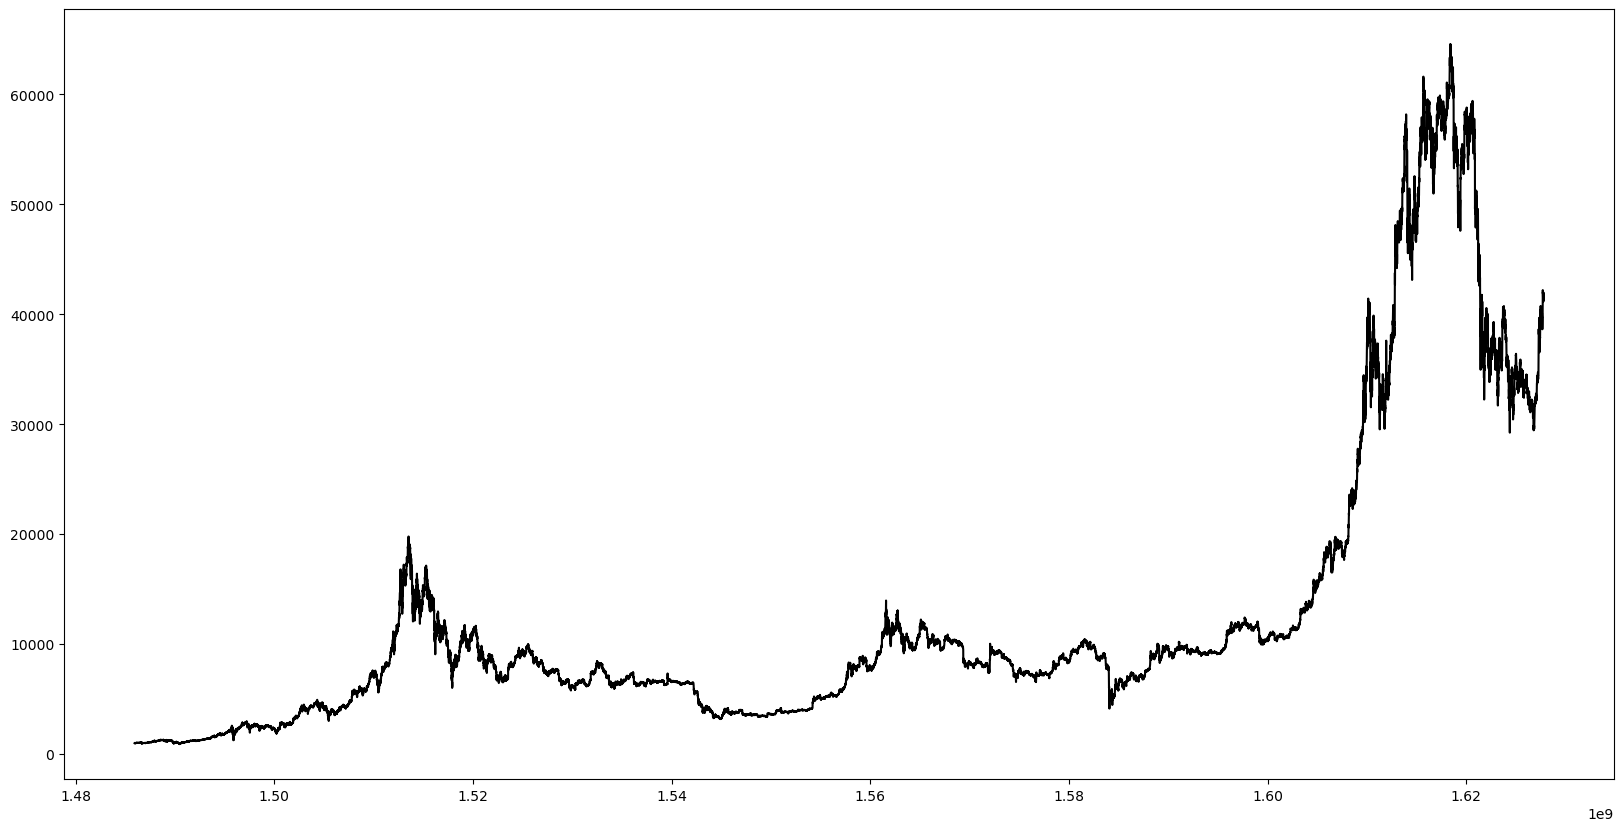

In [15]:
# Plot the open column of the data set
fig, ax1 = plt.subplots(figsize=(20,10))

ax1.plot(tickdata.loc[:,'open'], color="black")

In [16]:
# Generate 20 X-Blocks with a size of 48 timesteps
# The generated X-blocks do not have column names any more, as they are just an array

xBlockGenerator = DataStreamCreator.XBlockGenerator(tick_and_indicator_DF=tickdata,
                                                    generator_batch_size=20,
                                                    X_Block_lenght=48
                                                    )
xBlocks = next(xBlockGenerator)
print(f"tickdata.shape: {tickdata.shape}")
print(f"xBlocks.shape: {xBlocks.shape}")

tickdata.shape: (39403, 6)
xBlocks.shape: (20, 48, 6)


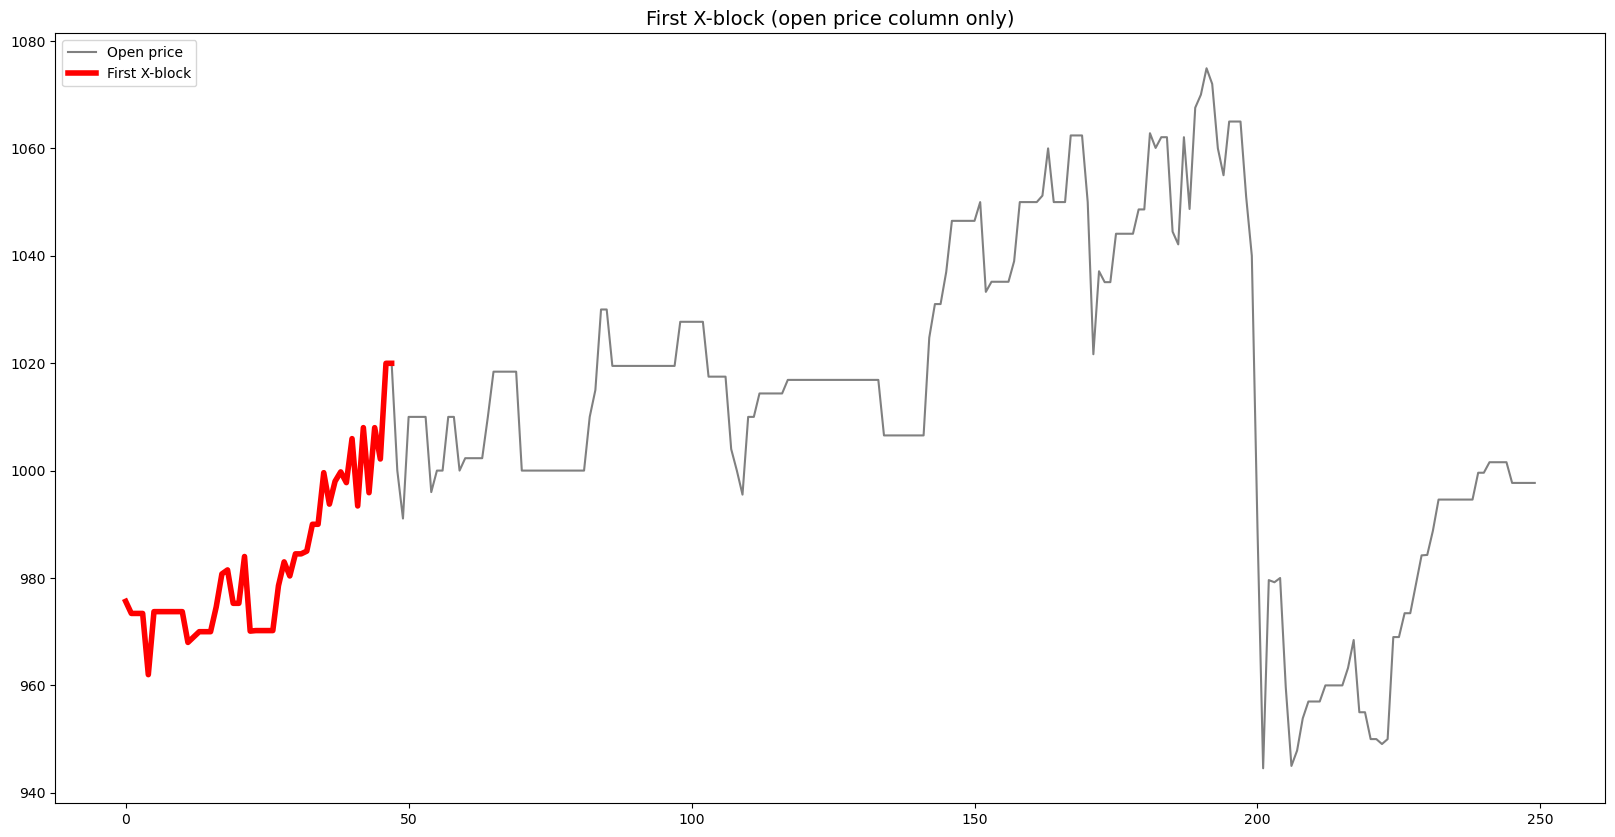

In [17]:
# Plot the first X-Block
chart_name="First X-block (open price column only)"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

x_len = 250

# Plot the 'baseline'
ax1.plot(tickdata.loc[:,'open'].values[:x_len], color="gray", label="Open price")

# Plot the first block
ax1.plot(xBlocks[0,:,0], color="red", linewidth = 4, label="First X-block")

# Show a legend
plt.legend(loc="upper left")

# Save the figure
fig_name = chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

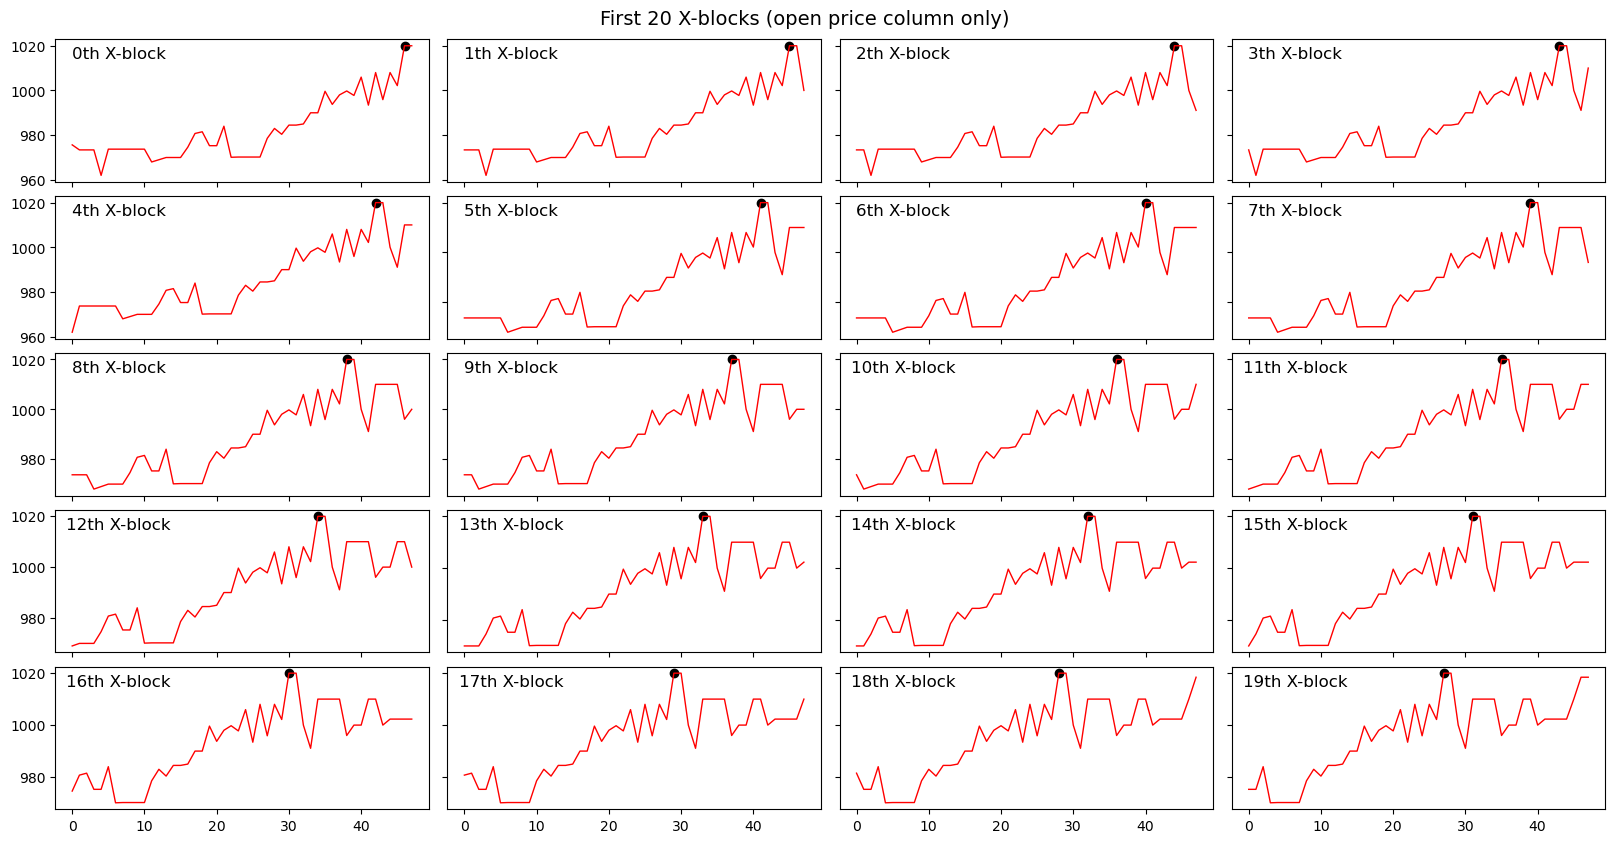

In [18]:
# Plot the first 20 X-blocks
nHorzontal = 5
nVertical = 4
i = 0

chart_name="First 20 X-blocks (open price column only)"
fig, axs = plt.subplots(nHorzontal, nVertical,figsize=(20,10))
fig.subplots_adjust(wspace=0.05, hspace=0.1)

fig.suptitle(chart_name, fontsize=14, y=0.91)

markerX = xBlocks[0,:,0][-2]

for nH in range(nHorzontal):
    for nV in range(nVertical):
        # Set the title
        axs[nH, nV].set_title(f"{i}th X-block", x=0.17, y=1.0, pad=-14)
        
        # Plot the i-th block
        axs[nH, nV].plot(xBlocks[i,:,0], color="red", linewidth = 1, label=f"{i}th X-block")
        
        # Plot a marker to visualize the movement
        axs[nH, nV].scatter(x=[xBlocks.shape[1]-2-i], y=[markerX], color="black")
                
        i+=1

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Save the figure
fig_name = chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

In [19]:
# Generate X-Blocks until there is no more data to get the block
# at the end of the dataset

latest_blocks = None

while True:
  try:
    latest_blocks = next(xBlockGenerator)
  except StopIteration:
    # Exit if there is no more data
    break
latest_blocks.shape

(15, 48, 6)

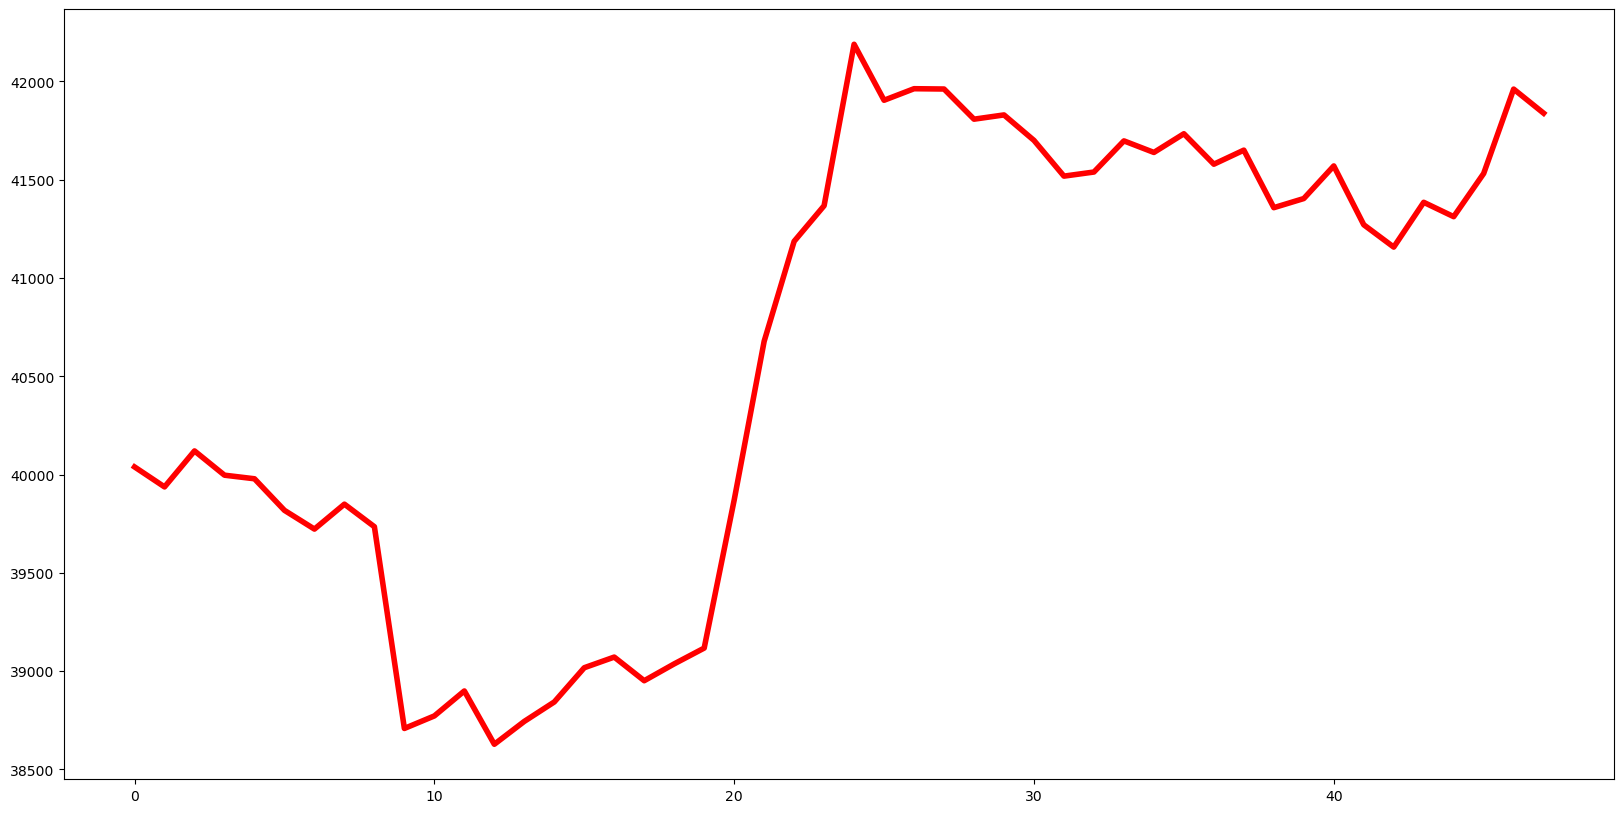

In [20]:
# Plot the latest data
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(latest_blocks[-1,:,0], color="red", linewidth = 4)

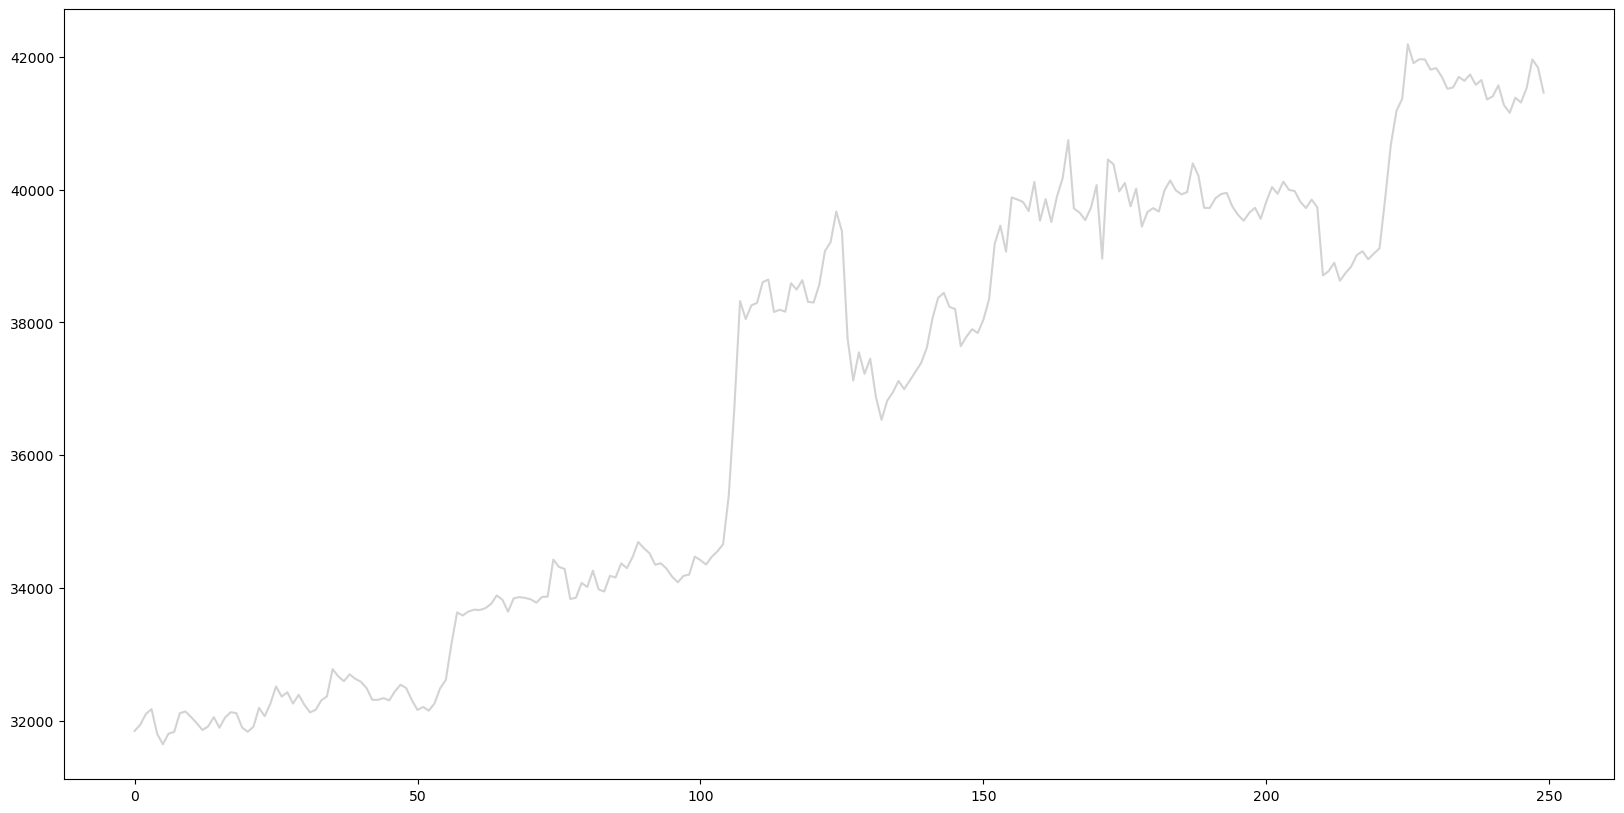

In [21]:
# Plot the end of the data table
fig, ax1 = plt.subplots(figsize=(20,10))

ax1.plot(tickdata.loc[:,'open'].values[-250:], color="lightgray")